In [71]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
# File system manangement
import os
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [81]:
df = pd.read_excel("/Users/linhtran/Downloads/Time series: Forecasting Analysis/Sample - Superstore.xls")

#Check how many categories there are in the data
df['Category'].unique()



array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [82]:
#We're going to do time series analysis and forecasting for The Office Supplies
office_sup = df.loc[df['Category'] == 'Office Supplies']

In [83]:
#Check scale of time
office_sup['Order Date'].min(), office_sup['Order Date'].max()


(Timestamp('2014-01-03 00:00:00'), Timestamp('2017-12-30 00:00:00'))

## Data Preprocessing

In [84]:
# List files available
df.head(2)



,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820


This step includings removing columns that we dont need, check missing values, agg sales by date and so on.

In [85]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
office_sup.drop(cols, axis=1, inplace=True)
office_sup = office_sup.sort_values('Order Date')
office_sup.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [86]:
office_sup = office_sup.groupby('Order Date')['Sales'].sum().reset_index()


In [87]:
office_sup.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


## Indexing with Time Series Data


In [88]:
office_sup = office_sup.set_index('Order Date')
office_sup.index

DatetimeIndex(['2014-01-03', '2014-01-04', '2014-01-05', '2014-01-06',
               '2014-01-07', '2014-01-09', '2014-01-10', '2014-01-13',
               '2014-01-16', '2014-01-18',
               ...
               '2017-12-21', '2017-12-22', '2017-12-23', '2017-12-24',
               '2017-12-25', '2017-12-26', '2017-12-27', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=1148, freq=None)

we use the averages daily sales value for that month instead, and use the start of each month as the timestamp

In [89]:
y = office_sup['Sales'].resample('MS').mean()


In [90]:

y['2017':]

Order Date
2017-01-01     967.013136
2017-02-01     389.882737
2017-03-01     538.899481
2017-04-01     558.229296
2017-05-01     508.776444
2017-06-01     650.463038
2017-07-01     393.902615
2017-08-01    1156.148154
2017-09-01    1139.137250
2017-10-01     886.045846
2017-11-01    1124.012036
2017-12-01    1049.549724
Freq: MS, Name: Sales, dtype: float64

## Visualizing Office Supplies sales time series data

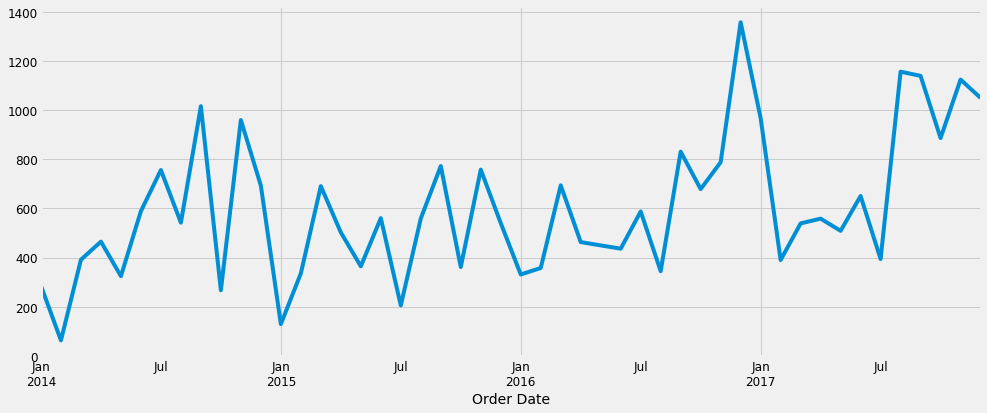

In [91]:
y.plot(figsize=(15, 6))
plt.show()

The time-series plot show some interesting seasonality partterns here such that sales are always low at the beginning of the year and start to peak at the later half of the year. 

We can also see that the increasing trend of Office Supplies Sale throughout the years from 2014 to 2017.

#### Now we decompose the time-series plot into 3 distinct components: trend, seasonality, and noise; using the method called "time-series decomposition"

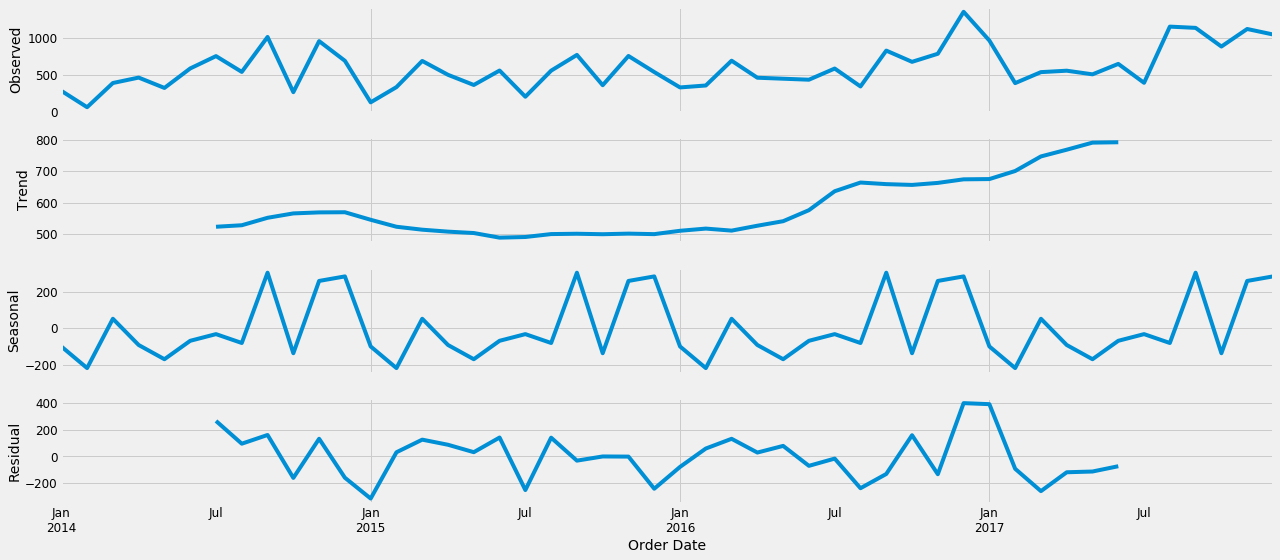

In [92]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The above plot clearly shows the seasonality of the Office Supplies sales and it's quite unstable

## Time series forecasting with ARIMA (Autoregressive Integrated Moving Average)


In [93]:
#Select parameter for the ARIMA Time Series model

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [94]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1337.4225446452328
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:516.0876543936834
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1128.9895652260632
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:347.44488563489716
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:702.6891395292458
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3042.4730462250673
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:487.76014158147586
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:517.4952646586528
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2602.904288820577
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:345.69220944601216
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1487.4933068613577
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:500.0109385290892
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1639.2138044146873
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:335.7148959418817
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:637.3530008828154
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2600.0435300550957
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:473.7153967455427
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:489.94199700276863


The above output suggests that SARIMAX(1, 1, 1)x(1, 1, 0, 12) yields the lowest AIC value of 318.20. Therefore we should consider this to be optimal option.

## Fitting the Model

In [102]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2479      0.328      0.755      0.450      -0.395       0.891
ma.L1         -0.9389      0.462     -2.030      0.042      -1.845      -0.032
ar.S.L12      -0.6135      0.348     -1.762      0.078      -1.296       0.069
sigma2      7.421e+04   2.68e+04      2.768      0.006    2.17e+04    1.27e+05


The 'summary' table shows the results from the output of SARIMAX. The 'coef' column shows the weight (importance) of each feature and how each one impacts the time series. The 'P>|z|' column informs us of the significance of each feature weight. Here, each weight has p-value lower or closer to 0.05, so it is reasonable to retain all of them.

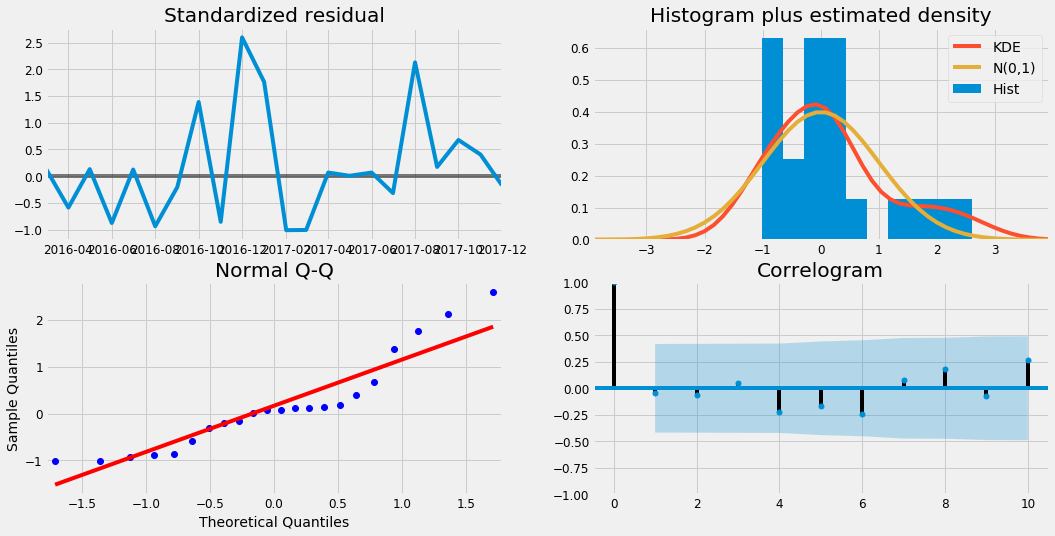

In [103]:
#Run model diagnosis to investigate any unusual behavior, to make sure that none of the assumptions made by the model
# is violated. 

results.plot_diagnostics(figsize=(16, 8))
plt.show()

Primary Concern: ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA doesnt satisfy these properties, it means that it can be improved

We can see here that

- Top right: the red KDE line follows closely with the N(0,1) line (N(0,1) is the standard notation for a normal distribution with mean 0, and std = 1) -> good indication that the residuls are normally distributed

- Bottom Left: qq plot shows that the ordered distribution of residuals (blue dots) follow not quite closely, but  not too significantly the linear trend of the samples taken from the normal distribution with N(0,1)

- The residuals over time (top left) don't display any obvious seasonality. Though it is not perfect (shown in the autocorrelation plot on the bottom right), our model diagnostics suggests that our model is residuals are near normally distributed.



## Validating Forecast


In [104]:
# Now we can use the model to produce forecasts
# Start by comparing predicted values to real values of the time series, so that we can understand the accuarcy of our forecast
# we set forecasts to start at 2017–01–01 to the end of the data.

pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()


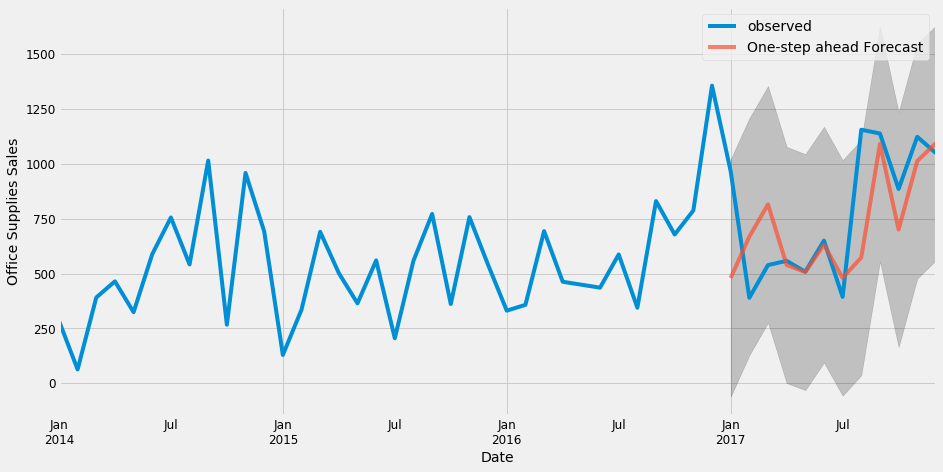

In [106]:
# Plot the real and forecasted values of the Time Series, see how well we did.

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()

plt.show()

Overall the forecasts align with the true value quite well, showing the upward trend toward the end of the year.

In [111]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 65844.6


In [109]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Root Mean Squared Error of our forecasts is 256.6


    RMSE tells us that the model was able to forecast the average daily office supplies sale in the test set within 256.6 of the real sales. Our office supplies daily sales ranging from around 2 to over 10000. In my opinion, this is a pretty good model so far.

In [122]:
office_sup.describe()

,Sales
count,1148.000000
mean,626.347589
std,995.566806
min,1.788000
25%,80.853500
50%,284.455000
75%,744.390000
max,10142.354000


## Producing and visualizing forecasts



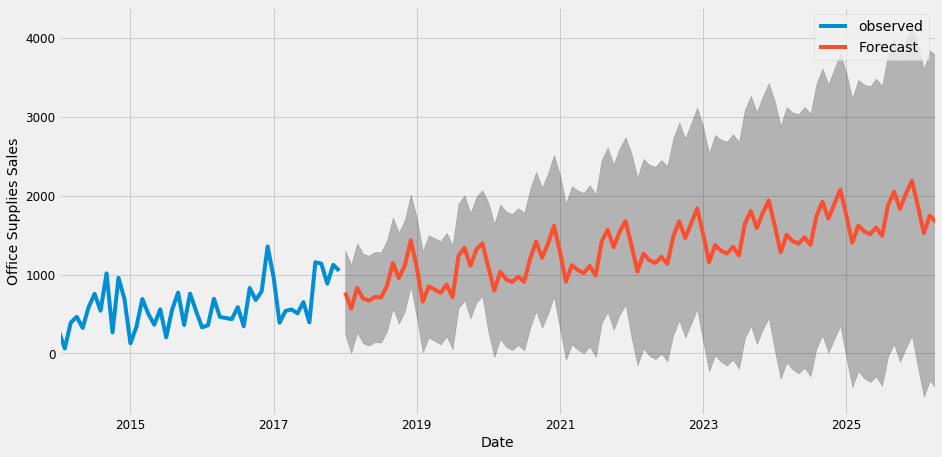

In [123]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Office Supplies Sales')
plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality, as well as the upward trend. As we forecast further out into the future, it's natural that we become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.



## Time Series comparison Technology sales and Office Supplies


In [149]:
# Data Processing
technology = df.loc[df['Category'] == 'Technology']
office_sup = df.loc[df['Category'] == 'Office Supplies']

In [150]:
technology.shape, office_sup.shape

((1847, 21), (6026, 21))

We can see here that there are many more number of sales from Office supplies than Technology over the years

In [151]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
technology.drop(cols, axis=1, inplace=True)
office_sup.drop(cols, axis=1, inplace=True)

technology = technology.sort_values('Order Date')
office_sup = office_sup.sort_values('Order Date')

technology = technology.groupby('Order Date')['Sales'].sum().reset_index()
office_sup = office_sup.groupby('Order Date')['Sales'].sum().reset_index()


In [152]:
technology.head()

,Order Date,Sales
0,2014-01-06,1147.94
1,2014-01-09,31.20
2,2014-01-13,646.74
3,2014-01-15,149.95
4,2014-01-16,124.20


In [153]:
office_sup.head()

,Order Date,Sales
0,2014-01-03,16.448
1,2014-01-04,288.060
2,2014-01-05,19.536
3,2014-01-06,685.340
4,2014-01-07,10.430


## Data Exploration

In [155]:
# Combine two data frames into one and plot these two categories' time series into one plot.
technology = technology.set_index('Order Date')
office_sup = office_sup.set_index('Order Date')

y_technology = technology['Sales'].resample('MS').mean()
y_office_sup = office_sup['Sales'].resample('MS').mean()

technology = pd.DataFrame({'Order Date':y_technology.index, 'Sales':y_technology.values})
office_sup = pd.DataFrame({'Order Date': y_office_sup.index, 'Sales': y_office_sup.values})

store = technology.merge(office_sup, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'technology_sales', 'Sales_y': 'office_sup_sales'}, inplace=True)
store.head()

,Order Date,technology_sales,office_sup_sales
0,2014-01-01,449.041429,285.357647
1,2014-02-01,229.787143,63.042588
2,2014-03-01,2031.948375,391.176318
3,2014-04-01,613.028933,464.794750
4,2014-05-01,564.698588,324.346545


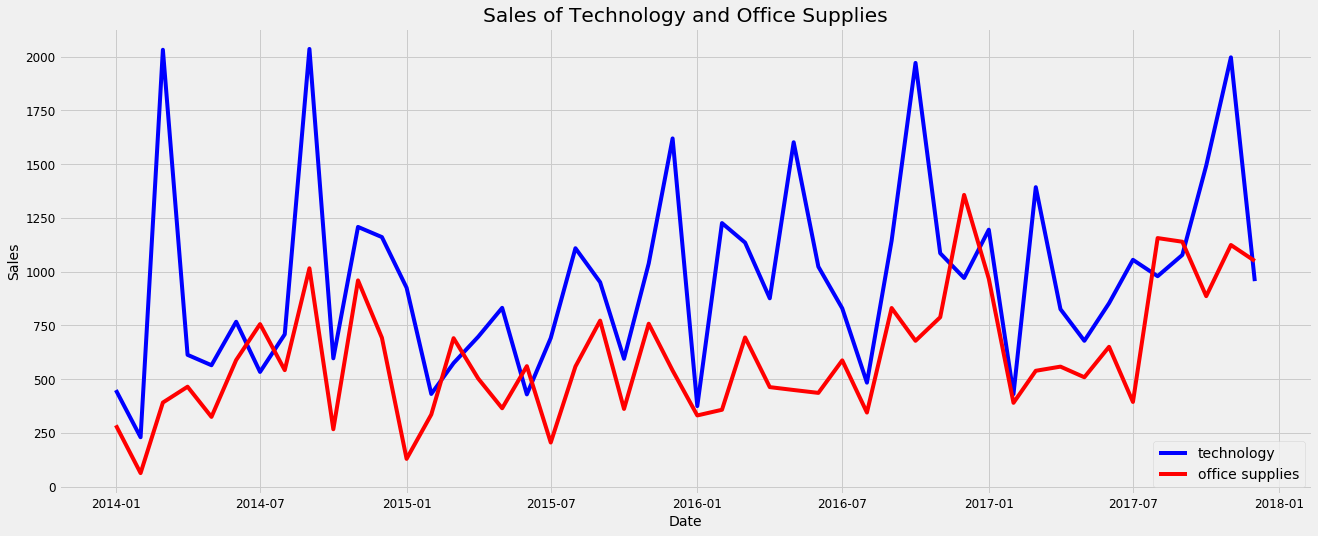

In [159]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['technology_sales'], 'b-', label = 'technology')
plt.plot(store['Order Date'], store['office_sup_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Technology and Office Supplies')
plt.legend()
plt.show()

It shows that the sales of tech and office supplies shared a quite similar seasonal pattern. Early of the year is the off season for both of the 2 categories. Sales only start to peak up in the later end of the year. In addition, average daily sales for technology are higher than those of office supplies in most of the months. It is understandable, as the value of technology should be much higher than those of office supplies. Occationaly, office supplies passed furnitue on average daily sales. 


In [160]:
first_date = store.ix[np.min(list(np.where(store['office_sup_sales'] > store['technology_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than tech is {}.".format(first_date.date()))

Office supplies first time produced higher sales than tech is 2014-07-01.
